In [1]:
# Simple PGD Attack Demo
# This is a self-contained demo that creates and attacks a sample image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ==============================================================================
# PART 1: Load a Pretrained Model
# ==============================================================================

print("\n" + "="*50)
print("PART 1: Loading pretrained model...")
print("="*50)

# Load a pretrained ResNet-18 model
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()  # Set to evaluation mode
print("✓ Loaded ResNet-18 model")


Using device: cpu

PART 1: Loading pretrained model...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


✓ Loaded ResNet-18 model


In [3]:
# ==============================================================================
# PART 2: Create or Load a Sample Image
# ==============================================================================

print("\n" + "="*50)
print("PART 2: Creating sample image...")
print("="*50)

def create_sample_image():
    """
    Create a simple synthetic image or load from CIFAR-10
    """
    try:
        # Try to load from CIFAR-10
        transform = transforms.Compose([
            transforms.Resize(224),  # ResNet expects 224x224
            transforms.ToTensor(),
        ])

        testset = torchvision.datasets.CIFAR10(
            root='./data',
            train=False,
            download=True,
            transform=transform
        )

        # Get the first image (airplane)
        image, label = testset[1]  # Index 1 is usually a nice car image
        print("✓ Loaded CIFAR-10 image")
        return image.unsqueeze(0), label  # Add batch dimension

    except:
        # Create a synthetic image if CIFAR-10 fails
        print("Creating synthetic image...")
        # Create a simple gradient image
        image = torch.zeros(1, 3, 224, 224)
        for i in range(224):
            for j in range(224):
                image[0, 0, i, j] = i / 224  # Red gradient
                image[0, 1, i, j] = j / 224  # Green gradient
                image[0, 2, i, j] = (i + j) / 448  # Blue gradient
        print("✓ Created synthetic gradient image")
        return image, 0

# Create/load image
original_image, true_label = create_sample_image()
original_image = original_image.to(device)

# ImageNet normalization (required for pretrained models)
mean = torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
std = torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)


PART 2: Creating sample image...


100%|██████████| 170M/170M [00:01<00:00, 94.6MB/s]


✓ Loaded CIFAR-10 image



Class: 814
Confidence: 62.28%


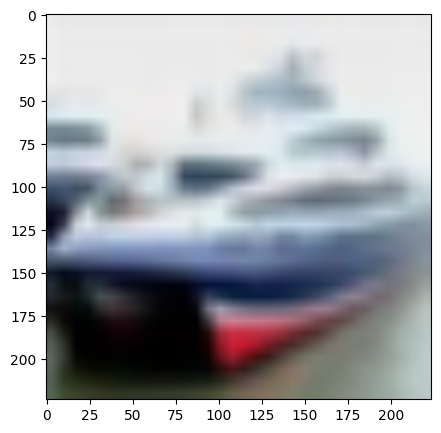

In [13]:
# Print the image
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(original_image.cpu().squeeze().permute(1, 2, 0))

# Print class from resnet for this image
with torch.no_grad():
    normalized = (original_image - mean) / std
    output = model(normalized)
    probs = F.softmax(output, dim=1)
    pred = output.max(1)[1].item()
    conf = probs.max().item()
    # print class
    print(f"\nClass: {pred}")
    print(f"Confidence: {conf:.2%}")


In [4]:
# ==============================================================================
# PART 3: PGD Attack Implementation
# ==============================================================================

print("\n" + "="*50)
print("PART 3: Implementing PGD Attack...")
print("="*50)

def pgd_attack(model, images, labels, epsilon=8/255, alpha=2/255, num_steps=20):
    """
    Simple PGD Attack

    Args:
        model: Neural network model
        images: Input images [batch, channels, height, width]
        labels: True labels
        epsilon: Maximum perturbation (L-infinity norm)
        alpha: Step size
        num_steps: Number of PGD iterations

    Returns:
        adv_images: Adversarial images
        all_losses: Loss at each step
    """

    # Make a copy of the original images
    adv_images = images.clone().detach()

    # Random initialization within epsilon ball
    random_noise = torch.zeros_like(adv_images).uniform_(-epsilon, epsilon)
    adv_images = adv_images + random_noise
    adv_images = torch.clamp(adv_images, 0, 1)  # Keep in valid range

    # Track losses for visualization
    all_losses = []

    print(f"\nRunning PGD with:")
    print(f"  Epsilon: {epsilon:.4f}")
    print(f"  Alpha: {alpha:.4f}")
    print(f"  Steps: {num_steps}")
    print("\nIteration progress:")

    for step in range(num_steps):
        adv_images.requires_grad = True

        # Normalize images for model
        normalized = (adv_images - mean) / std

        # Forward pass
        outputs = model(normalized)

        # Calculate loss (we want to maximize this)
        if labels is not None:
            loss = F.cross_entropy(outputs, torch.tensor([labels]).to(device))
        else:
            # If no label, just use the top prediction
            loss = -outputs.max()

        all_losses.append(loss.item())

        # Print progress every 5 steps
        if step % 5 == 0:
            _, predicted = outputs.max(1)
            print(f"  Step {step:2d}: Loss = {loss.item():.4f}, Predicted class = {predicted.item()}")

        # Backward pass
        loss.backward()

        # Get gradient sign
        grad_sign = adv_images.grad.sign()

        # Update adversarial images (gradient ascent)
        adv_images = adv_images.detach() + alpha * grad_sign

        # Project back to epsilon ball (L-infinity)
        delta = torch.clamp(adv_images - images, -epsilon, epsilon)
        adv_images = images + delta

        # Clamp to valid image range [0, 1]
        adv_images = torch.clamp(adv_images, 0, 1)

    print(f"\n✓ PGD Attack complete!")

    return adv_images, all_losses


PART 3: Implementing PGD Attack...


In [5]:
# ==============================================================================
# PART 4: Run the Attack
# ==============================================================================

print("\n" + "="*50)
print("PART 4: Running PGD attack...")
print("="*50)

# Get original prediction
with torch.no_grad():
    normalized_orig = (original_image - mean) / std
    orig_output = model(normalized_orig)
    orig_probs = F.softmax(orig_output, dim=1)
    orig_pred = orig_output.max(1)[1].item()
    orig_conf = orig_probs.max().item()

print(f"\nOriginal prediction:")
print(f"  Class: {orig_pred}")
print(f"  Confidence: {orig_conf:.2%}")

# Run PGD attack with different epsilon values
epsilon_values = [4/255, 8/255, 16/255]
results = {}

for eps in epsilon_values:
    print(f"\n{'='*30}")
    print(f"Attacking with epsilon = {eps:.4f} ({eps*255:.1f}/255)")
    print('='*30)

    adv_image, losses = pgd_attack(
        model=model,
        images=original_image,
        labels=true_label,
        epsilon=eps,
        alpha=eps/10,  # Alpha proportional to epsilon
        num_steps=20
    )

    # Get adversarial prediction
    with torch.no_grad():
        normalized_adv = (adv_image - mean) / std
        adv_output = model(normalized_adv)
        adv_probs = F.softmax(adv_output, dim=1)
        adv_pred = adv_output.max(1)[1].item()
        adv_conf = adv_probs.max().item()

    print(f"\nAdversarial prediction:")
    print(f"  Class: {adv_pred}")
    print(f"  Confidence: {adv_conf:.2%}")
    print(f"  Attack {'SUCCESSFUL' if adv_pred != orig_pred else 'FAILED'} ✓" if adv_pred != orig_pred else "")

    # Store results
    results[eps] = {
        'adv_image': adv_image,
        'adv_pred': adv_pred,
        'adv_conf': adv_conf,
        'losses': losses,
        'success': adv_pred != orig_pred
    }


PART 4: Running PGD attack...

Original prediction:
  Class: 814
  Confidence: 62.28%

Attacking with epsilon = 0.0157 (4.0/255)

Running PGD with:
  Epsilon: 0.0157
  Alpha: 0.0016
  Steps: 20

Iteration progress:
  Step  0: Loss = 11.7061, Predicted class = 814
  Step  5: Loss = 46.5274, Predicted class = 814
  Step 10: Loss = 59.5719, Predicted class = 814
  Step 15: Loss = 68.2640, Predicted class = 814

✓ PGD Attack complete!

Adversarial prediction:
  Class: 814
  Confidence: 100.00%


Attacking with epsilon = 0.0314 (8.0/255)

Running PGD with:
  Epsilon: 0.0314
  Alpha: 0.0031
  Steps: 20

Iteration progress:
  Step  0: Loss = 10.0354, Predicted class = 563
  Step  5: Loss = 41.8745, Predicted class = 418
  Step 10: Loss = 54.9070, Predicted class = 418
  Step 15: Loss = 65.8711, Predicted class = 418

✓ PGD Attack complete!

Adversarial prediction:
  Class: 418
  Confidence: 100.00%
  Attack SUCCESSFUL ✓

Attacking with epsilon = 0.0627 (16.0/255)

Running PGD with:
  Epsilon


PART 5: Visualizing results...


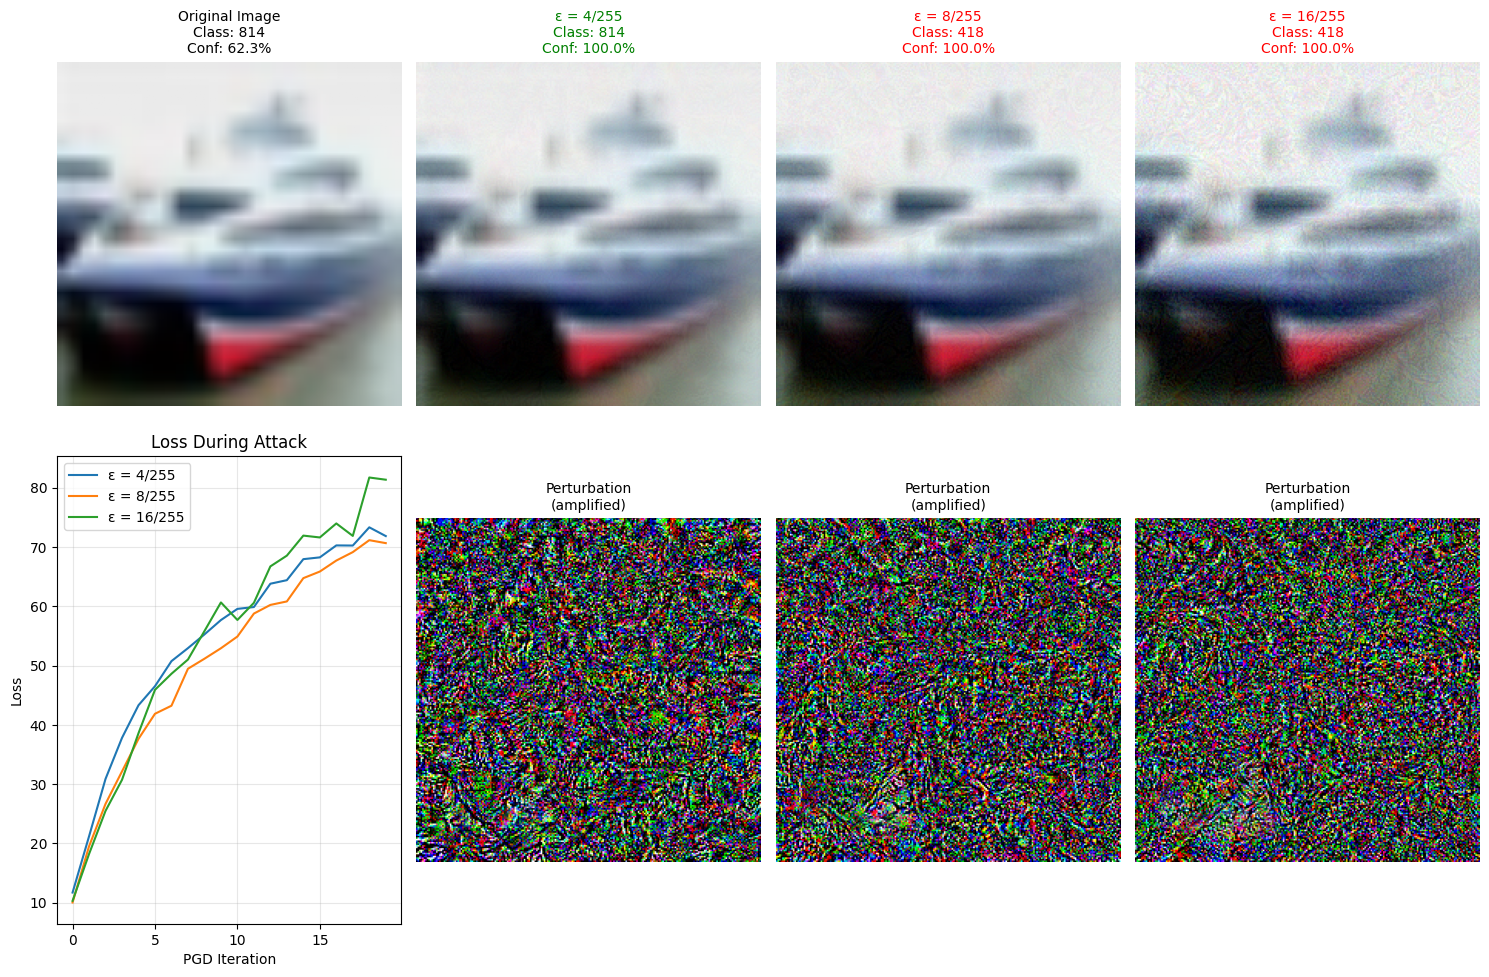


✓ Visualization complete! Saved as 'pgd_demo_results.png'


In [6]:
# ==============================================================================
# PART 5: Visualize Results
# ==============================================================================

print("\n" + "="*50)
print("PART 5: Visualizing results...")
print("="*50)

def tensor_to_numpy_image(tensor):
    """Convert tensor to numpy array for visualization"""
    img = tensor.cpu().squeeze().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)
    return img

# Create visualization
fig = plt.figure(figsize=(15, 10))

# Plot original image
ax1 = plt.subplot(2, 4, 1)
ax1.imshow(tensor_to_numpy_image(original_image))
ax1.set_title(f'Original Image\nClass: {orig_pred}\nConf: {orig_conf:.1%}', fontsize=10)
ax1.axis('off')

# Plot adversarial images for each epsilon
for idx, eps in enumerate(epsilon_values):
    result = results[eps]

    # Adversarial image
    ax = plt.subplot(2, 4, idx + 2)
    ax.imshow(tensor_to_numpy_image(result['adv_image']))
    title_color = 'red' if result['success'] else 'green'
    ax.set_title(f'ε = {eps*255:.0f}/255\nClass: {result["adv_pred"]}\nConf: {result["adv_conf"]:.1%}',
                 fontsize=10, color=title_color)
    ax.axis('off')

    # Perturbation (amplified for visibility)
    ax_pert = plt.subplot(2, 4, idx + 6)
    perturbation = result['adv_image'] - original_image
    pert_display = tensor_to_numpy_image(perturbation)
    # Amplify for visibility
    pert_display = (pert_display - pert_display.min()) / (pert_display.max() - pert_display.min() + 1e-8)
    ax_pert.imshow(pert_display)
    ax_pert.set_title(f'Perturbation\n(amplified)', fontsize=10)
    ax_pert.axis('off')

# Plot loss curves
ax_loss = plt.subplot(2, 4, 5)
for eps in epsilon_values:
    ax_loss.plot(results[eps]['losses'], label=f'ε = {eps*255:.0f}/255')
ax_loss.set_xlabel('PGD Iteration')
ax_loss.set_ylabel('Loss')
ax_loss.set_title('Loss During Attack')
ax_loss.legend()
ax_loss.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('pgd_demo_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Visualization complete! Saved as 'pgd_demo_results.png'")

In [7]:
# ==============================================================================
# PART 6: Analysis
# ==============================================================================

print("\n" + "="*50)
print("PART 6: Attack Analysis")
print("="*50)

print("\nSummary of Results:")
print("-" * 40)

for eps in epsilon_values:
    result = results[eps]
    perturbation = result['adv_image'] - original_image
    l_inf = perturbation.abs().max().item()
    l_2 = perturbation.norm(p=2).item()

    print(f"\nEpsilon = {eps*255:.1f}/255:")
    print(f"  Attack Success: {'✓ Yes' if result['success'] else '✗ No'}")
    print(f"  Original → Adversarial: {orig_pred} → {result['adv_pred']}")
    print(f"  Confidence drop: {orig_conf:.1%} → {result['adv_conf']:.1%}")
    print(f"  Actual L∞ norm: {l_inf:.4f}")
    print(f"  Actual L₂ norm: {l_2:.4f}")



PART 6: Attack Analysis

Summary of Results:
----------------------------------------

Epsilon = 4.0/255:
  Attack Success: ✗ No
  Original → Adversarial: 814 → 814
  Confidence drop: 62.3% → 100.0%
  Actual L∞ norm: 0.0157
  Actual L₂ norm: 3.7513

Epsilon = 8.0/255:
  Attack Success: ✓ Yes
  Original → Adversarial: 814 → 418
  Confidence drop: 62.3% → 100.0%
  Actual L∞ norm: 0.0314
  Actual L₂ norm: 7.3841

Epsilon = 16.0/255:
  Attack Success: ✓ Yes
  Original → Adversarial: 814 → 418
  Confidence drop: 62.3% → 100.0%
  Actual L∞ norm: 0.0627
  Actual L₂ norm: 14.6040


In [8]:
# ==============================================================================
# PART 7: Save Adversarial Examples
# ==============================================================================

print("\n" + "="*50)
print("PART 7: Saving adversarial examples...")
print("="*50)

# Save tensors for later use
torch.save({
    'original': original_image.cpu(),
    'adversarial_4_255': results[4/255]['adv_image'].cpu(),
    'adversarial_8_255': results[8/255]['adv_image'].cpu(),
    'adversarial_16_255': results[16/255]['adv_image'].cpu(),
}, 'pgd_adversarial_examples.pt')

print("✓ Saved adversarial examples to 'pgd_adversarial_examples.pt'")

print("\n" + "="*50)
print("PGD DEMO COMPLETE!")
print("="*50)

print("\nKey Observations:")
print("1. Larger epsilon → Stronger attacks (more likely to succeed)")
print("2. Larger epsilon → More visible perturbations")
print("3. PGD iteratively increases the loss to fool the model")
print("4. The attack projects back to the epsilon ball at each step")


PART 7: Saving adversarial examples...
✓ Saved adversarial examples to 'pgd_adversarial_examples.pt'

PGD DEMO COMPLETE!

Key Observations:
1. Larger epsilon → Stronger attacks (more likely to succeed)
2. Larger epsilon → More visible perturbations
3. PGD iteratively increases the loss to fool the model
4. The attack projects back to the epsilon ball at each step
